**Library import**

In [66]:
from igraph import Graph, VertexClustering
from collections import Counter
from igraph import plot
import pandas as pd
import numpy as np

---
**Models definition**

In [108]:
VERTICES_NUMBER = 1000

class SpecializedGraph:
    def __init__(self, vertices: np.ndarray, edges: np.ndarray):
        self.number_of_vertices = len(vertices)
        self.number_of_edges = len(edges)
        self.vertices = vertices
        self.edges = edges
        assert edges.shape[1] == 2
        self.degrees = np.zeros((self.number_of_vertices,))

        for edge in edges:
            self.degrees[edge[0]] += 1
            self.degrees[edge[1]] += 1

    def modularity(self, labels: np.ndarray, k_max: int):
        degree_per_cluster = np.bincount(labels, self.degrees, minlength=k_max)

        from_clusters = labels[self.edges[:, 0]]
        to_clusters = labels[self.edges[:, 1]]

        mask = (from_clusters == to_clusters)

        edges_per_cluster = np.bincount(from_clusters[mask], minlength=k_max).astype('int32')

        modularity = np.sum(edges_per_cluster / self.number_of_edges) - np.sum((degree_per_cluster / (2 * self.number_of_edges)) ** 2)

        return modularity
    

class Partition:
    def __init__(self, number_of_vertices: np.ndarray, k_max: int, clusters: list = None, force_clusters_use: bool = False):
        assert k_max < 256
        self.number_of_vertices = number_of_vertices
        self.k_max = k_max
        self.fitness = 0
        self.gene_len = 1

        while 2**(self.gene_len) < k_max:
            self.gene_len += 1

        self.chromosome = np.random.randint(2, size=(number_of_vertices, self.gene_len, 2)).astype('float64')
        if clusters:
            for vertex in clusters:
                assert clusters[vertex] < 256
            bits = np.unpackbits(np.array(clusters, dtype='uint8'),
                                bitorder='little').reshape((len(clusters), 8))[:, 0:self.gene_len]
            self.chromosome[:, :, 0] = bits
            random_values = np.random.uniform(0, 0.1, size=(number_of_vertices, self.gene_len, 2))
            if force_clusters_use:
                random_values = np.random.uniform(0, 0.01, size=(number_of_vertices, self.gene_len, 2))
            self.chromosome = np.where(self.chromosome < 0.5, self.chromosome + random_values,
                                       self.chromosome - random_values)

        self.chromosome[:, :, 1] = np.sqrt(1 - self.chromosome[:, :, 0]**2)

        self.collapsed_chromosome = None

    def __copy__(self):
        obj = Partition(self.number_of_vertices, self.k_max)
        obj.fitness = self.fitness
        obj.gene_len = self.gene_len
        obj.chromosome = np.copy(self.chromosome)
        obj.collapsed_chromosome = np.copy(self.collapsed_chromosome)
        return obj

    def collapse(self):
        labels = np.zeros((self.number_of_vertices,), dtype='int32')
        measure = np.random.uniform(size=(self.chromosome.shape[0], self.chromosome.shape[1]))
        measured_chromosome = (self.chromosome[:, :, 0]**2) >= (measure**2)
        labels = np.packbits(measured_chromosome, axis=1, bitorder='little').flatten()
        labels = labels % self.k_max
        self.collapsed_chromosome = labels

    def calculate_fitness(self, graph: SpecializedGraph):
        self.fitness = graph.modularity(self.collapsed_chromosome, self.k_max)
        self.fitness = (self.fitness + 0.5) * 2 / 3

    def mutation(self, number_of_mutations: int = 1):
        assert number_of_mutations >= 1

        new_partition = Partition(self.number_of_vertices, self.k_max)
        new_partition.chromosome = np.copy(self.chromosome)

        for _ in range(number_of_mutations):
            gene, location = np.random.randint(0, self.number_of_vertices), np.random.randint(0, self.gene_len)
            alpha, beta = new_partition.chromosome[gene][location][0], new_partition.chromosome[gene][location][1]
            new_partition.chromosome[gene][location][0], new_partition.chromosome[gene][location][1] = beta, alpha

        return new_partition


def crossover(partition1: Partition, partition2: Partition) -> Partition:
    child = Partition(partition1.number_of_vertices, partition1.k_max)

    adamart_operator = np.array([
        [1, 1],
        [1, -1]
    ]) / np.sqrt(2)

    xgate_operator = np.array([
        [0, 1],
        [1, 0]
    ])

    mask_adamart = (partition1.collapsed_chromosome == partition2.collapsed_chromosome)
    mask_xgate = (partition1.collapsed_chromosome != partition2.collapsed_chromosome)
    child.chromosome[mask_adamart] = child.chromosome[mask_adamart] @ adamart_operator.T
    child.chromosome[mask_xgate] = child.chromosome[mask_xgate] @ xgate_operator.T
    return child

---

**Data Preprocessing**

In [109]:
links = pd.read_csv("dataset/links.csv")

links = links.drop(['index', '_id', 'update_time', 'home_domain', 'link_domain', 'username', 'name'], axis=1)
links = links.dropna()
links = links[links['type'] == 'partnership'].drop(['type'], axis=1)
links = links.drop_duplicates()

def get_degrees(companies: list) -> list:
    return sorted(list(Counter(companies).items()), key=lambda x: -x[1])

companies = np.concatenate(
        (links['home_name'], links['link_name'])
        ).astype('str')
candidate_companies = np.array([elem[0] for elem in get_degrees(companies)])
companies = candidate_companies[300:300+VERTICES_NUMBER]

map_companies = dict()
for idx, company in enumerate(companies):
    map_companies[company] = idx

edges = set()
for link in links.values:
    if (map_companies.get(link[0], '') != '') and (map_companies.get(link[1], '') != ''):
        company1 = min(map_companies[link[0]], map_companies[link[1]])
        company2 = max(map_companies[link[0]], map_companies[link[1]])
        edges.add((company1, company2))
    
edges = np.array(list(edges))
print(f"Number of edges: {len(edges)}")

C:\Users\fatkh\AppData\Local\Temp\ipykernel_19332\2419730042.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  links = pd.read_csv("dataset/links.csv")


Number of edges: 5523


---
**QIAEA execution**

In [110]:
def run_qiaea(population_size: int, number_of_vertices: int, number_of_males: int, max_number_of_clusters: int,
              number_of_epochs: int, graph: SpecializedGraph, queen_lifetime_epochs: int = 20, initial_queen_partition: list = None):

    assert number_of_males < population_size

    population = [Partition(number_of_vertices, max_number_of_clusters) for _ in range(population_size)]
    if initial_queen_partition:
        population[0] = Partition(number_of_vertices, max_number_of_clusters, initial_queen_partition, force_clusters_use=True)
        for i in range(1, population_size):
          population[i] = Partition(number_of_vertices, max_number_of_clusters, initial_queen_partition)

    for partition in population:
        partition.collapse()
        partition.calculate_fitness(graph)
    population.sort(key=lambda x: -x.fitness)

    best_solution = population[0].__copy__()

    for epoch in range(1, number_of_epochs+1):
        # Crossover operations
        for i in range(1, number_of_males+1):
            population.append(crossover(population[0], population[i]))
        # Mutation operations
        for i in range(1, population_size+1):
            population.append(population[i].mutation(20))
        # Measure operations
        for i in range(population_size, len(population)):
            population[i].collapse()
        # Fitness calculation
        for i in range(population_size, len(population)):
            population[i].calculate_fitness(graph)
        population.sort(key=lambda x: -x.fitness)
        # Queen elimination operation
        if epoch % queen_lifetime_epochs == 0:
            population = population[1:population_size+1]
        else:
            population = population[:population_size]

        if population[0].fitness > best_solution.fitness:
            best_solution = population[0].__copy__()

        print(f"Epoch {epoch}, queen fitness: {population[0].fitness:.6f}, best fitness: {best_solution.fitness:.6f}")
    
    return best_solution

In [71]:
specialized_graph = SpecializedGraph(companies, edges)
population_size = 150
epochs = 500
max_number_of_clusters = 2
best_solution = run_qiaea(population_size, VERTICES_NUMBER, population_size//2, max_number_of_clusters, epochs, specialized_graph, 100)

Epoch 1, queen fitness: 0.344265, best fitness: 0.344265
Epoch 2, queen fitness: 0.344889, best fitness: 0.344889
Epoch 3, queen fitness: 0.345838, best fitness: 0.345838
Epoch 4, queen fitness: 0.345838, best fitness: 0.345838
Epoch 5, queen fitness: 0.345838, best fitness: 0.345838
Epoch 6, queen fitness: 0.345838, best fitness: 0.345838
Epoch 7, queen fitness: 0.345838, best fitness: 0.345838
Epoch 8, queen fitness: 0.345838, best fitness: 0.345838
Epoch 9, queen fitness: 0.345838, best fitness: 0.345838
Epoch 10, queen fitness: 0.345838, best fitness: 0.345838
Epoch 11, queen fitness: 0.345838, best fitness: 0.345838
Epoch 12, queen fitness: 0.345838, best fitness: 0.345838
Epoch 13, queen fitness: 0.345838, best fitness: 0.345838
Epoch 14, queen fitness: 0.345838, best fitness: 0.345838
Epoch 15, queen fitness: 0.345838, best fitness: 0.345838
Epoch 16, queen fitness: 0.345838, best fitness: 0.345838
Epoch 17, queen fitness: 0.345838, best fitness: 0.345838
Epoch 18, queen fitness

---
**Evaluation**

In [111]:
graph = Graph(directed=False)
graph.add_vertices(VERTICES_NUMBER)
graph.add_edges(edges)
graph.vs['name'] = companies

In [112]:
# qiaea_clusters = VertexClustering(graph, best_solution.collapsed_chromosome)
greedy_clusters = graph.community_fastgreedy().as_clustering(n=200)
leiden_clusters = graph.community_leiden(resolution=0.05)
# newman_girvan_clusters = graph.community_edge_betweenness().as_clustering(n=16)

In [113]:
# print(f"QIAEA modularity: {qiaea_clusters.modularity:.3f}")
print(f"Greedy algorithm modularity: {graph.modularity(greedy_clusters.membership):.3f}")
print(f"Leiden algorithm modularity: {graph.modularity(leiden_clusters.membership):.3f}")
# print(f"Newman-Girvan algorithm modularity: {newman_girvan_clusters.modularity:.3f}")

Greedy algorithm modularity: 0.312
Leiden algorithm modularity: 0.290


---
**QIAEA as improvement over other clustering techniques**

In [114]:
population_size = 100
epochs = 2000
max_number_of_clusters = 255
best_solution = run_qiaea(population_size, VERTICES_NUMBER, population_size//2, max_number_of_clusters,
                          epochs, specialized_graph, 1000, leiden_clusters.membership)

Epoch 1, queen fitness: 0.512386, best fitness: 0.512386
Epoch 2, queen fitness: 0.512386, best fitness: 0.512386
Epoch 3, queen fitness: 0.512386, best fitness: 0.512386
Epoch 4, queen fitness: 0.512386, best fitness: 0.512386
Epoch 5, queen fitness: 0.512386, best fitness: 0.512386
Epoch 6, queen fitness: 0.512386, best fitness: 0.512386
Epoch 7, queen fitness: 0.512386, best fitness: 0.512386
Epoch 8, queen fitness: 0.512386, best fitness: 0.512386
Epoch 9, queen fitness: 0.512386, best fitness: 0.512386
Epoch 10, queen fitness: 0.512386, best fitness: 0.512386
Epoch 11, queen fitness: 0.512386, best fitness: 0.512386
Epoch 12, queen fitness: 0.512386, best fitness: 0.512386
Epoch 13, queen fitness: 0.512386, best fitness: 0.512386
Epoch 14, queen fitness: 0.512386, best fitness: 0.512386
Epoch 15, queen fitness: 0.512386, best fitness: 0.512386
Epoch 16, queen fitness: 0.512386, best fitness: 0.512386
Epoch 17, queen fitness: 0.512386, best fitness: 0.512386
Epoch 18, queen fitness

---
**Graph clustering visualization**

Модулярность кластеризации: 0.269


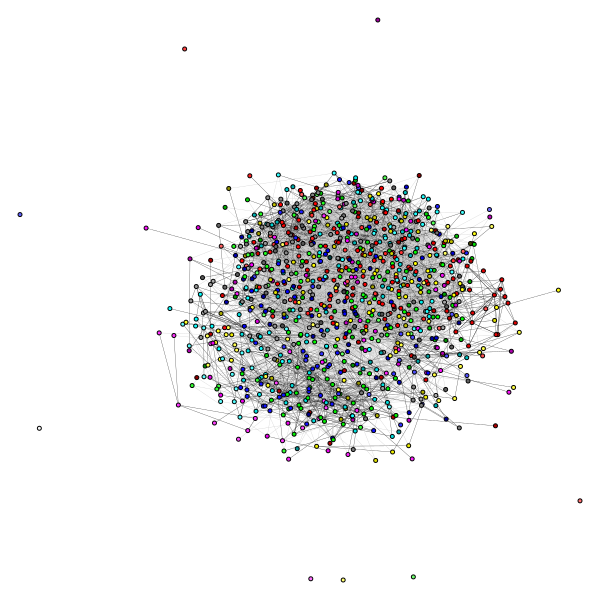

In [115]:
clusters = VertexClustering(graph, best_solution.collapsed_chromosome)
layout = graph.layout("kk")
visual_style = {
    "vertex_color": [i for i in clusters.membership],
    "vertex_size": 4,
    "edge_width": 0.3,
    "layout": layout
}
modularity = clusters.modularity
print(f"Модулярность кластеризации: {modularity:.3f}")
plot(clusters, **visual_style)